In [1]:
# By Hsiang-Huei You 1007054642
# Nov 8 2021

!pip install openpyxl
import pandas as pd
import numpy as np
import seaborn as sns

  Using cached openpyxl-3.0.9-py2.py3-none-any.whl (242 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


In [2]:
## SCHEMA ##

# tDimCountry TA
## >>> int - iCountryID - t7.'CountryCode' <pk>
## >>> string - sCountryName - t7.2
## >>> int - iContinentID - T7.5 - ref to TB.1
## >>> int - iRegionID - T7.8 - ref to TC.1
## >>> b - bDeveloped - T7.10
## >>> b - bLeastDeveloped - T7.11
## >>> b - bSubSaharanAfrica - T7.12
## >>> b - bMoreDeveloped - t1.Notes = '(b)'
### >>>>> manual extraction from notes table
## >>> b - bLessDeveloped - t1.Notes = '(c)'
### >>>>> manual extraction from notes table
## >>> i - iNoteID - t1.Notes
## >>> b - bForeignBornPop - T1.5 (where B)
## >>> b - bForeignCitizens - T1.5 (where C)
## >>> b - bRefugee - T1.5 (where R)
## >>> b - bImputationEstimation - T1.5 (where I)

# tDimContinent TB
## >>> int - iContinentID - T7.5
## >>> string - sContinentName t7.4

# tDimGroup TBB
## >>> int - iRefID -T1.4 - entered manually
## >>> string - sGroupName T1.2 - entered manually

# tDimRegion TC
## >>> int - iRegionID - T7.8
## >>> string - sRegionName t7.7

# tDimNotes TD
## >>> int - sNoteID - matches to TA.iCountryID, TB.iContinentID, TC.iRegionID
## >>> string - sNote - t1.Notes (where is number)

# tDimSortOrder TE 
## >>> iRefID - matches TA.iCountryID, TB.iContinentID, TC.iRegionID
## >>> iSortOrder

# tMigration TF
## int - iCountryId - Ref to TA.1
## int - iYear - T1 row 16
## Char - cGender - t1 row 15, grouped (L-Q,R-W) - {'M','F'}
## int - iMigrants - t1 L-W

# tPopulation TG
## int - iCountryId - Ref to TA.1
## int - iYear - T2 row 16
## Char - cGender - t2 row 15, grouped (K-P,Q-V) - {'M','F'}
## int - fPopulation - t2 L-W

# tRefugee TH
## int - iCountryId - Ref to TA.1
## int - iYear - T6 row 16
## int - iRefugee - t6 F-K


In [3]:
# Step 1: import data

#>> load the data from Tab 7 - "Annex"

T7 = pd.read_excel (r'UN_MigrantStockTotal_2015.xlsx',sheet_name='ANNEX',header=None, 
                    names = ['iCountryID','sCountryName','iCountrySort','sContinentName','iContinentID',
                            'iContinentSort','sRegionName','iRegionID','iRegionSort','bDeveloped',
                             'bLeastDeveloped','bSubSaharanAfrica'],
                   skiprows = 15)


#>> load the data from Tab 8 - Notes

T8 = pd.read_excel (r'UN_MigrantStockTotal_2015.xlsx',sheet_name='NOTES',header=None,names = ['sNoteID','sNote']
                    , skiprows = 20)


#>> load the data from Tab 1 - Migration

T1 = pd.read_excel (r'UN_MigrantStockTotal_2015.xlsx',sheet_name='Table 1',header=None, skiprows = 16,
                    names = ['iSortOrder','sCountryName','iNoteID','iCountryID','sDataType','1990_both_migrant',
                             '1995_both_migrant','2000_both_migrant','2005_both_migrant','2010_both_migrant','2015_both_migrant',
                             '1990_male_migrant','1995_male_migrant','2000_male_migrant','2005_male_migrant','2010_male_migrant','2015_male_migrant',
                             '1990_female_migrant','1995_female_migrant','2000_female_migrant','2005_female_migrant','2010_female_migrant','2015_female_migrant']
                   ,dtype = {2: str})

T1 = T1.drop(['1990_both_migrant', '1995_both_migrant','2000_both_migrant','2005_both_migrant','2010_both_migrant','2015_both_migrant'], axis=1)

#T1['iNoteID'].where(pd.notnull(T1['iNoteID']), '')

#>> load the data from Tab 2 - Population

T2 = pd.read_excel (r'UN_MigrantStockTotal_2015.xlsx',sheet_name='Table 2',header=None,  skiprows = 24,
                    names = ['iSortOrder','sCountryName','iNoteID','iCountryID','1990_both_population',
                             '1995_both_population','2000_both_population','2005_both_population','2010_both_population','2015_both_population',
                             '1990_male_population','1995_male_population','2000_male_population','2005_male_population','2010_male_population','2015_male_population',
                             '1990_female_population','1995_female_population','2000_female_population','2005_female_population','2010_female_population','2015_female_population'])

##T2 = T2.drop(['1990_both_population','1995_both_population','2000_both_population','2005_both_population','2010_both_population','2015_both_population'],axis=1)

#>> load the data from Tab 6 - Refugees

T6 = pd.read_excel (r'UN_MigrantStockTotal_2015.xlsx',sheet_name='Table 6',header=None, skiprows = 24,
                    names = ['iSortOrder','sCountryName','iNoteID','iCountryID','sDataType','1990_refugee',
                             '1995_refugee','2000_refugee','2005_refugee','2010_refugee','2015_refugee',
                             '1990_percentage','1995_percentage','2000_percentage','2005_percentage','2010_percentage','2015_percentage',
                             '1990_1995_rate','1995_2000_rate','2000_2005_rate','2005_2010_rate','2010_2015_rate'])

T6 = T6.drop(['1990_percentage','1995_percentage','2000_percentage','2005_percentage','2010_percentage','2015_percentage',
                             '1990_1995_rate','1995_2000_rate','2000_2005_rate','2005_2010_rate','2010_2015_rate'],axis=1)



In [4]:
## TE - Sort Order
## >>> iRefID - index - matches TA.iCountryID, TB.iContinentID, TC.iRegionID
## >>> iSortOrder

T1.sort_values(by = 'iSortOrder',inplace=True)

TE = pd.DataFrame(columns=['iRefID','iSortOrder'])

#TE.index.name = 'iRefID'

for i in range(len(T1)):
    TE.loc[i] = [T1.iloc[i]['iCountryID'],T1.iloc[i]['iSortOrder']]
    
print(TE)

    iRefID iSortOrder
0      900          1
1      901          2
2      902          3
3      941          4
4      934          5
..     ...        ...
260    882        261
261    772        262
262    776        263
263    798        264
264    876        265

[265 rows x 2 columns]


In [5]:
## clean T1


T7.sort_values(by = ['iCountryID'],inplace=True)
T1.sort_values(by = ['iCountryID'],inplace=True)

i = 0 # index for T1
j = 0 # index for T7


T1_cleaned = T1.iloc[:0,:].copy() #create an empty table that copies the headers of T1


while (1): #only keep records that are related to countries
    if T1.iloc[i].loc["iCountryID"] == T7.iloc[j].loc["iCountryID"] : #match
        T1_cleaned = T1_cleaned.append(T1.iloc[i])
        j+=1
        i+=1
    else: i+=1

    if (i == len(T7)):
            break

T1 = T1_cleaned

In [6]:
### Build TA - Countries

# tDimCountry TA
## >>> int - index -  iCountryID - t7.'CountryCode' <pk>
## >>> string - sCountryName - t7.2
## >>> int - iContinentID - T7.5 - ref to TB.1
## >>> int - iRegionID - T7.8 - ref to TC.1
## >>> b - bDeveloped - T7.10
## >>> b - bLeastDeveloped - T7.11
## >>> b - bSubSaharanAfrica - T7.12
## >>> b - bMoreDeveloped - t1.Notes = '(b)'
### >>>>> manual extraction from notes table
## >>> b - bLessDeveloped - t1.Notes = '(c)'
### >>>>> manual extraction from notes table
## >>> i - iNoteID - t1.Notes
## >>> b - bForeignBornPop - T1.5 (where B)
## >>> b - bForeignCitizens - T1.5 (where C)
## >>> b - bRefugee - T1.5 (where R)
## >>> b - bImputationEstimation - T1.5 (where I)

TA = T7

TA = TA.drop(['iCountrySort','sContinentName','iContinentSort','sRegionName','iRegionSort'], axis = 1)

TA.sort_values(by = ['iCountryID'],inplace=True)

T1.sort_values(by = ['iCountryID'],inplace=True)

i = 0 # index for T1
j = 0 # index for T7

TA['iNoteID'] = 0 ## add a new column to TA for the notes ID

TA['bForeignBornPop'] = 0 # - T1.5 (where B)
TA['bForeignCitizens'] = 0 # - T1.5 (where C)
TA['bRefugee'] = 0 # - T1.5 (where R)
TA['bImputationEstimation'] = 0 # - T1.5 (where I)


TA['bMoreDeveloped'] = 0 # - t1.Notes = '(b)'
TA['bLessDeveloped'] = 0 # - t1.Notes = '(c)'



while (1): #only keep records that are related to countries
    if T1.iloc[i].loc['iCountryID'] == TA.iloc[j].loc['iCountryID'] : #match
        
        if(not(pd.isna(T1.iloc[i].loc['iNoteID']))):
            TA.iloc[j, TA.columns.get_loc('iNoteID')] =  int(T1.iloc[i].loc['iNoteID'].lstrip('(').rstrip(')'))
        else:
            TA.iloc[j, TA.columns.get_loc('iNoteID')] = int(0)
        
        if ('B' in T1.iloc[i].loc['sDataType']):
            TA.iloc[j, TA.columns.get_loc('bForeignBornPop')] = 1
        if ('C' in T1.iloc[i].loc['sDataType']):
            TA.iloc[j, TA.columns.get_loc('bForeignCitizens')] = 1
        if ('R' in T1.iloc[i].loc['sDataType']):
            TA.iloc[j, TA.columns.get_loc('bRefugee')] = 1
        if ('I' in T1.iloc[i].loc['sDataType']):
            TA.iloc[j, TA.columns.get_loc('bImputationEstimation')] = 1
            
        if(TA.iloc[j].loc['bDeveloped'] == "Yes"):
                TA.iloc[j, TA.columns.get_loc('bDeveloped')] = 1
        else:
            TA.iloc[j, TA.columns.get_loc('bDeveloped')] = 0
            
        if(TA.iloc[j].loc['bLeastDeveloped'] == "Yes"):
                TA.iloc[j, TA.columns.get_loc('bLeastDeveloped')] = 1
        else:
            TA.iloc[j, TA.columns.get_loc('bLeastDeveloped')] = 0
            
        if(TA.iloc[j].loc['bSubSaharanAfrica'] == "Yes"):
                TA.iloc[j, TA.columns.get_loc('bSubSaharanAfrica')] = 1
        else:
            TA.iloc[j, TA.columns.get_loc('bSubSaharanAfrica')] = 0            
            
        if(TA.iloc[j].loc['iContinentID'] in [908, 905] # Europe, Northern America
            or TA.iloc[j].loc['iRegionID'] == 927 #Australia/New Zealand
            or TA.iloc[j].loc['iCountryID'] == 392): #Japan
            
            TA.iloc[j, TA.columns.get_loc('bMoreDeveloped')] = 1
            
        if(TA.iloc[j].loc['iContinentID'] in [903, 904] #Africa, Latin America and the Caribbean 
            or (TA.iloc[j].loc['iContinentID'] == 935 and TA.iloc[j].loc['iCountryID'] != 392) # Asia (except Japan), 
            or TA.iloc[j].loc['iRegionID'] in [928,954,957]): # Melanesia, Micronesia, Polynesia
            
            TA.iloc[j, TA.columns.get_loc('bLessDeveloped')] = 1
            
        j+=1
        i+=1
                        
    else: i+=1

    if (i == len(T1)):
            break
            
#TA.set_index('iCountryID', inplace=True)
            
print(TA)

     iCountryID                        sCountryName  iContinentID  iRegionID  \
0             4                         Afghanistan           935       5501   
1             8                             Albania           908        925   
2            12                             Algeria           903        912   
3            16                      American Samoa           909        957   
4            20                             Andorra           908        925   
..          ...                                 ...           ...        ...   
225         862  Venezuela (Bolivarian Republic of)           904        931   
227         876           Wallis and Futuna Islands           909        957   
177         882                               Samoa           909        957   
229         887                               Yemen           935        922   
230         894                              Zambia           903        910   

    bDeveloped bLeastDeveloped bSubSaha

In [7]:
## TB - continents

# tDimContinent TB
## >>> int - iContinentID - (assigned) - T7.5
## >>> string - sContinentName t7.4

T7.sort_values(by = 'iContinentID',inplace=True)

i = 0 
j = 1

for i in range(1,len(T7)):
    if(T7.iloc[i].loc['iContinentID'] != T7.iloc[i-1].loc['iContinentID']):
        j = j+1

TB = pd.DataFrame(columns=['iContinentID','sContinentName'], index=range(j))

i = 0 
j = 1

TB.iloc[0] = [T7.iloc[0].loc['iContinentID'],T7.iloc[0].loc['sContinentName']]

for i in range(1,len(T7)):
    if(T7.iloc[i].loc['iContinentID'] != T7.iloc[i-1].loc['iContinentID']):
        TB.iloc[j] = [T7.iloc[i].loc['iContinentID'],T7.iloc[i].loc['sContinentName']]
        j = j+1
        
#TB.set_index('iContinentID', inplace = True)
        
print(TB)

  iContinentID                   sContinentName
0          903                           Africa
1          904  Latin America and the Caribbean
2          905                 Northern America
3          908                           Europe
4          909                          Oceania
5          935                             Asia


In [8]:
# tDimGroup TBB
## >>> int - iRefID - index - T1.4 - entered manually
## >>> string - sGroupName T1.2 - entered manually

TBB = pd.DataFrame(columns=['iRefID','sGroupName'])

TBB.loc[0] = [900,'WORLD']
TBB.loc[1] = [901,'Developed regions']
TBB.loc[2] = [902,'Developing regions']
TBB.loc[3] = [941,'Least developed countries']
TBB.loc[4] = [934,'Less developed regions excluding least developed countries']
TBB.loc[5] = [947,'Sub-Saharan Africa']

#TBB.index.name = 'iRefID'

print(TBB)

  iRefID                                         sGroupName
0    900                                              WORLD
1    901                                  Developed regions
2    902                                 Developing regions
3    941                          Least developed countries
4    934  Less developed regions excluding least develop...
5    947                                 Sub-Saharan Africa


In [9]:
## TC - regions

# tDimRegion TC
## >>> int - iRegionID - (assigned) - T7.8
## >>> string - sRegionName t7.7


T7.sort_values(by = 'iRegionID',inplace=True)

i = 0 
j = 1

for i in range(1,len(T7)):
    if(T7.iloc[i].loc['iRegionID'] != T7.iloc[i-1].loc['iRegionID']):
        j = j+1

TC = pd.DataFrame(columns=['iRegionID','sRegionName'], index=range(j))

i = 0 
j = 1

TC.iloc[0] = [T7.iloc[0].loc['iRegionID'],T7.iloc[0].loc['sRegionName']]

for i in range(1,len(T7)):
    if(T7.iloc[i].loc['iRegionID'] != T7.iloc[i-1].loc['iRegionID']):
        TC.iloc[j] = [T7.iloc[i].loc['iRegionID'],T7.iloc[i].loc['sRegionName']]
        j = j+1

#TC.set_index('iRegionID', inplace = True)
        
print(TC)

   iRegionID                sRegionName
0        905           Northern America
1        906               Eastern Asia
2        910             Eastern Africa
3        911              Middle Africa
4        912            Northern Africa
5        913            Southern Africa
6        914             Western Africa
7        915                  Caribbean
8        916            Central America
9        920         South-Eastern Asia
10       922               Western Asia
11       923             Eastern Europe
12       924            Northern Europe
13       925            Southern Europe
14       926             Western Europe
15       927  Australia and New Zealand
16       928                  Melanesia
17       931              South America
18       954                 Micronesia
19       957                  Polynesia
20      5500               Central Asia
21      5501              Southern Asia


In [10]:
## TD - notes

TD = pd.DataFrame(columns=['iNoteID','sNote'], index=range(len(T8)))

i = 0

for i in range(len(T8)):
    TD.iloc[i] = [int(T8.iloc[i].loc['sNoteID'].lstrip('(').rstrip(')'))
                  ,T8.iloc[i].loc['sNote']]

#TD.set_index('iNoteID', inplace = True)

print(TD)

   iNoteID                                              sNote
0        1    Including Agalega, Rodrigues and Saint Brandon.
1        2                                Including Zanzibar.
2        3  The estimates for 1990 to 2005 refer to Sudan ...
3        4          Including Ascension and Tristan da Cunha.
4        5  For statistical purposes, the data for China d...
5        6  As of 1 July 1997, Hong Kong became a Special ...
6        7  As of 20 December 1999, Macao became a Special...
7        8                       Including Sabah and Sarawak.
8        9                        Including Nagorno-Karabakh.
9       10                         Including Northern-Cyprus.
10      11              Including Abkhazia and South Ossetia.
11      12  Including East Jerusalem. Refugees are not par...
12      13                            Including Transnistria.
13      14                    Refers to Guernsey, and Jersey.
14      15                           Including Åland Islands.
15      

In [11]:
## TF

## int - iCountryId 
## int - iYear - T1 row 16
## Char - cGender - t1 row 15, grouped (L-Q,R-W) - {'M','F'}
## int - iPopulation - t1 L-W

i = 0 # index over T1

TF = pd.DataFrame(columns=['iCountryID', 'iYear', 'cGender','iMigrants'])

for i in range(len(T1)):
    temp_country = T1.iloc[i].loc['iCountryID']
    TF.loc[i*12+1] = [temp_country,1990,'M',T1.iloc[i].loc['1990_male_migrant']]
    TF.loc[i*12+2] = [temp_country,1995,'M',T1.iloc[i].loc['1995_male_migrant']]
    TF.loc[i*12+3] = [temp_country,2000,'M',T1.iloc[i].loc['2000_male_migrant']]
    TF.loc[i*12+4] = [temp_country,2005,'M',T1.iloc[i].loc['2005_male_migrant']]
    TF.loc[i*12+5] = [temp_country,2010,'M',T1.iloc[i].loc['2010_male_migrant']]
    TF.loc[i*12+6] = [temp_country,2015,'M',T1.iloc[i].loc['2015_male_migrant']]
    
    TF.loc[i*12+7] = [temp_country,1990,'F',T1.iloc[i].loc['1990_female_migrant']]
    TF.loc[i*12+8] = [temp_country,1995,'F',T1.iloc[i].loc['1995_female_migrant']]
    TF.loc[i*12+9] = [temp_country,2000,'F',T1.iloc[i].loc['2000_female_migrant']]
    TF.loc[i*12+10] = [temp_country,2005,'F',T1.iloc[i].loc['2005_female_migrant']]
    TF.loc[i*12+11] = [temp_country,2010,'F',T1.iloc[i].loc['2010_female_migrant']]
    TF.loc[i*12+12] = [temp_country,2015,'F',T1.iloc[i].loc['2015_female_migrant']]
    
##TF.replace(to_replace='..', value=None) # clean blanks, replace with NULL

TF = TF[np.isfinite(pd.to_numeric(TF.iMigrants, errors="coerce"))]

#TF.set_index('iCountryID', inplace = True)

print(TF)
    

     iCountryID iYear cGender iMigrants
1             4  1990       M     32558
2             4  1995       M     39105
3             4  2000       M     42848
4             4  2005       M     49274
5             4  2010       M     57709
...         ...   ...     ...       ...
2780        894  1995       F    119009
2781        894  2000       F    157547
2782        894  2005       F    124196
2783        894  2010       F     73862
2784        894  2015       F     63403

[2754 rows x 4 columns]


In [12]:
## TG - Population

# tPopulation TG
## int - iCountryId - Ref to TA.1
## int - iYear - T2 row 16
## Char - cGender - t2 row 15, grouped (K-P,Q-V) - {'M','F'}
## float - fPopulation - t2 L-W * 1000

T2.sort_values(by = ['iCountryID'],inplace=True)
T7.sort_values(by = ['iCountryID'],inplace=True)

i = 0 # index for T2
j = 0 # index for T7

T2_cleaned = T2.iloc[:0,:].copy() #create an empty table that copies the headers of T2

while (1): #only keep records that are related to countries
    if T2.iloc[i].loc["iCountryID"] == T7.iloc[j].loc["iCountryID"] : #match
        T2_cleaned = T2_cleaned.append(T2.iloc[i])
        #print(i,", ",j)
        i+=1
        j+=1
    else: i+=1

    if (i == len(T7)):
            break

T2 = T2_cleaned

i = 0 # index over T2

TG = pd.DataFrame(columns=['iCountryID', 'iYear', 'cGender','fPopulation'])

    
T2 = T2.replace(to_replace='..', value=None) # clean blanks, replace with NULL

for i in range(len(T2)):
    temp_country = T2.iloc[i].loc['iCountryID']
    
    TG.loc[i*18+1] = [temp_country,1990,'T',T2.iloc[i].loc['1990_both_population']]
    TG.loc[i*18+2] = [temp_country,1995,'T',T2.iloc[i].loc['1995_both_population']]
    TG.loc[i*18+3] = [temp_country,2000,'T',T2.iloc[i].loc['2000_both_population']]
    TG.loc[i*18+4] = [temp_country,2005,'T',T2.iloc[i].loc['2005_both_population']]
    TG.loc[i*18+5] = [temp_country,2010,'T',T2.iloc[i].loc['2010_both_population']]
    TG.loc[i*18+6] = [temp_country,2015,'T',T2.iloc[i].loc['2015_both_population']]
    
    TG.loc[i*18+7] = [temp_country,1990,'M',T2.iloc[i].loc['1990_male_population']]
    TG.loc[i*18+8] = [temp_country,1995,'M',T2.iloc[i].loc['1995_male_population']]
    TG.loc[i*18+9] = [temp_country,2000,'M',T2.iloc[i].loc['2000_male_population']]
    TG.loc[i*18+10] = [temp_country,2005,'M',T2.iloc[i].loc['2005_male_population']]
    TG.loc[i*18+11] = [temp_country,2010,'M',T2.iloc[i].loc['2010_male_population']]
    TG.loc[i*18+12] = [temp_country,2015,'M',T2.iloc[i].loc['2015_male_population']]
   
    TG.loc[i*18+13] = [temp_country,1990,'F',T2.iloc[i].loc['1990_female_population']]
    TG.loc[i*18+14] = [temp_country,1995,'F',T2.iloc[i].loc['1995_female_population']]
    TG.loc[i*18+15] = [temp_country,2000,'F',T2.iloc[i].loc['2000_female_population']]
    TG.loc[i*18+16] = [temp_country,2005,'F',T2.iloc[i].loc['2005_female_population']]
    TG.loc[i*18+17] = [temp_country,2010,'F',T2.iloc[i].loc['2010_female_population']]
    TG.loc[i*18+18] = [temp_country,2015,'F',T2.iloc[i].loc['2015_female_population']]
    
#TG.set_index('iCountryID', inplace=True)

print(TG)

     iCountryID iYear cGender  fPopulation
1             4  1990       T    12067.570
2             4  1995       T    16772.522
3             4  2000       T    19701.940
4             4  2005       T    24399.948
5             4  2010       T    27962.207
...         ...   ...     ...          ...
4172        894  1995       F     4664.427
4173        894  2000       F     5327.976
4174        894  2005       F     6046.071
4175        894  2010       F     6974.691
4176        894  2015       F     8118.120

[4176 rows x 4 columns]


In [13]:
## clean table TH


T6.sort_values(by = ['iCountryID'],inplace=True)

i = 0 # index for T6
j = 0 # index for T7

T6_cleaned = T6.iloc[:0,:].copy() #create an empty table that copies the headers of T6


while (1): #only keep records that are related to countries
    if T6.iloc[i].loc["iCountryID"] == T7.iloc[j].loc["iCountryID"] : #match
        T6_cleaned = T6_cleaned.append(T6.iloc[i])
        #print(i,", ",j)
        i+=1
        j+=1
    else: i+=1

    if (i == len(T7)):
            break

T6 = T6_cleaned

# tRefugee TH
## int - iCountryId - Ref to TA.1
## int - iYear - T6 row 16
## int - iRefugee - t6 F-K

T6.replace(to_replace='..', value=None) # clean blanks, replace with NULL

i = 0 # index over T2

TH = pd.DataFrame(columns=['iCountryID', 'iYear', 'iRefugee'])

for i in range(len(T6)):
    temp_country = T6.iloc[i].loc['iCountryID']
    TH.loc[i*6+1] = [temp_country,1990,T6.iloc[i].loc['1990_refugee']]
    TH.loc[i*6+2] = [temp_country,1995,T6.iloc[i].loc['1995_refugee']]
    TH.loc[i*6+3] = [temp_country,2000,T6.iloc[i].loc['2000_refugee']]
    TH.loc[i*6+4] = [temp_country,2005,T6.iloc[i].loc['2005_refugee']]
    TH.loc[i*6+5] = [temp_country,2010,T6.iloc[i].loc['2010_refugee']]
    TH.loc[i*6+6] = [temp_country,2015,T6.iloc[i].loc['2015_refugee']]
    
#TH.set_index('iCountryID',inplace=True)
    
print (TH) 

     iCountryID iYear iRefugee
1             4  1990       25
2             4  1995    19605
3             4  2000        0
4             4  2005       32
5             4  2010     6434
...         ...   ...      ...
1388        894  1995   129965
1389        894  2000   228663
1390        894  2005   155718
1391        894  2010    47857
1392        894  2015    24666

[1392 rows x 3 columns]


In [14]:
## SCHEMA ##

# tDimCountry TA
## >>> int - iCountryID - t7.'CountryCode' <pk>
## >>> string - sCountryName - t7.2
## >>> int - iContinentID - T7.5 - ref to TB.1
## >>> int - iRegionID - T7.8 - ref to TC.1
## >>> b - bDeveloped - T7.10
## >>> b - bLeastDeveloped - T7.11
## >>> b - bSubSaharanAfrica - T7.12
## >>> b - bMoreDeveloped - t1.Notes = '(b)'
### >>>>> manual extraction from notes table
## >>> b - bLessDeveloped - t1.Notes = '(c)'
### >>>>> manual extraction from notes table
## >>> i - iNoteID - t1.Notes
## >>> b - bForeignBornPop - T1.5 (where B)
## >>> b - bForeignCitizens - T1.5 (where C)
## >>> b - bRefugee - T1.5 (where R)
## >>> b - bImputationEstimation - T1.5 (where I)

# tDimContinent TB
## >>> int - iContinentID - T7.5
## >>> string - sContinentName t7.4

# tDimGroup TBB
## >>> int - iRefID -T1.4 - entered manually
## >>> string - sGroupName T1.2 - entered manually

# tDimRegion TC
## >>> int - iRegionID - T7.8
## >>> string - sRegionName t7.7

# tDimNotes TD
## >>> int - sNoteID - matches to TA.iCountryID, TB.iContinentID, TC.iRegionID
## >>> string - sNote - t1.Notes (where is number)

# tDimSortOrder TE 
## >>> iRefID - matches TA.iCountryID, TB.iContinentID, TC.iRegionID
## >>> iSortOrder

# tMigration TF
## int - iCountryId - Ref to TA.1
## int - iYear - T1 row 16
## Char - cGender - t1 row 15, grouped (L-Q,R-W) - {'M','F'}
## int - iMigrants - t1 L-W

# tPopulation TG
## int - iCountryId - Ref to TA.1
## int - iYear - T2 row 16
## Char - cGender - t2 row 15, grouped (K-P,Q-V) - {'M','F'}
## int - fPopulation - t2 L-W

# tRefugee TH
## int - iCountryId - Ref to TA.1
## int - iYear - T6 row 16
## int - iRefugee - t6 F-K


In [15]:
## part 2 - data analsysis - final assignement

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as clr


#li_color = ['Blues','GnBu','PuBu','PuBuGn','YlGnBu','mako','ocean','ocean_r','winter','winter_r']

colors = ['#08519c','#2171b5','#4292c6','#9ecae1','#969696','#d9d9d9']

custom_palette = sns.color_palette(colors)

#in the plot parameters:
#colormap=ListedColormap(custom_palette),


## Dec 12 2021

## step 0 - collapse gender column, get summary stats

TF1 = TF.groupby(["iCountryID","iYear"]).agg({'iMigrants':'sum'})
##TG1 = TG.groupby(["iCountryID","iYear"]).agg({'fPopulation':'sum'})
TG1 = TG[TG["cGender"] == "T"]

TG1 = TG1.drop(["cGender"], axis = 1)


## step 1 - join migration, refugee, and population data

#>> sources TA - country metadata, TF - migrant stock, TG - population info, TH - refugee info

TFG = pd.merge(TF1,TG1,how='inner',on=["iCountryID","iYear"])
TFGH = pd.merge(TFG,TH,how='inner',on=["iCountryID","iYear"])

## Step 2 - Add country metadata

TA1 = TA[["iCountryID","iContinentID","bLessDeveloped","bMoreDeveloped",
         "bSubSaharanAfrica","bLeastDeveloped","bDeveloped"]]


TAFGH = pd.merge(TFGH,TA1, how='inner',on=["iCountryID"])

TAFGH["MoP"] = TAFGH["iMigrants"] / (TAFGH["fPopulation"] * 1000)
TAFGH["RoP"] = TAFGH["iRefugee"] / (TAFGH["fPopulation"] * 1000)

print(TAFGH)

     iCountryID iYear  iMigrants  fPopulation iRefugee  iContinentID  \
0             4  1990      57686    12067.570       25           935   
1             4  1995      71522    16772.522    19605           935   
2             4  2000      75917    19701.940        0           935   
3             4  2005      87300    24399.948       32           935   
4             4  2010     102246    27962.207     6434           935   
...         ...   ...        ...          ...      ...           ...   
1372        894  1995     244338     9253.527   129965           903   
1373        894  2000     321167    10585.220   228663           903   
1374        894  2005     252749    12043.591   155718           903   
1375        894  2010     149637    13917.439    47857           903   
1376        894  2015     127915    16211.767    24666           903   

      bLessDeveloped  bMoreDeveloped bSubSaharanAfrica bLeastDeveloped  \
0                  1               0                 0       

iYear                1990      1995      2000      2005      2010      2015
name                                                                       
World            0.028879  0.028173  0.028325  0.029480  0.032102  0.033265
Least Developed  0.021963  0.020202  0.015323  0.013173  0.011824  0.012526
Less Developed   0.016262  0.014343  0.013937  0.014174  0.016398  0.017824
Developed        0.072019  0.078953  0.087002  0.096980  0.107478  0.112264


/tmp/ipykernel_44/2094358205.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tf1Least["name"] = "Least Developed"
/tmp/ipykernel_44/2094358205.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tf1Less["name"] = "Less Developed"
/tmp/ipykernel_44/2094358205.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

Text(0, 0.5, 'Migrants per Capita')

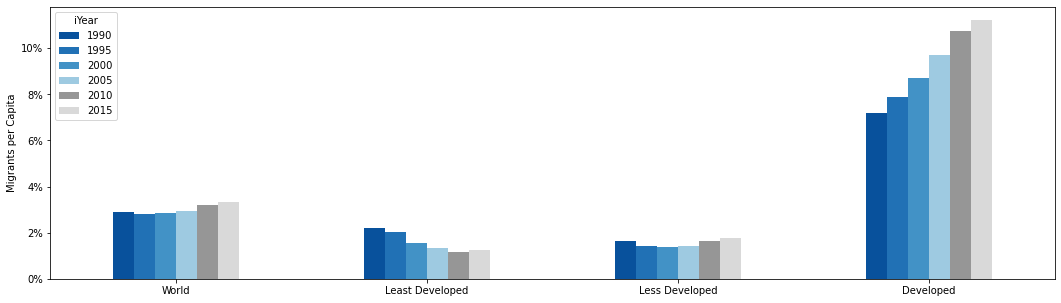

In [16]:
## Generate figure 1 - compare M/P by year by group

Tf1Least = TAFGH[(TAFGH["bLeastDeveloped"] == 1)]
Tf1Less = TAFGH[(TAFGH["bLeastDeveloped"] == 0) & (TAFGH["bLessDeveloped"] == 1)]
Tf1More = TAFGH[(TAFGH["bDeveloped"] == 1)]

Tf1Least["name"] = "Least Developed"
Tf1Less["name"] = "Less Developed"
Tf1More["name"] = "Developed"

#print(Tf1Least)
#print(Tf1Less)
#print(Tf1More)

Tf1a = pd.concat([Tf1Least,Tf1Less,Tf1More])
Tf1a = Tf1a.groupby(["iYear","name"]).agg({"iMigrants":"sum","fPopulation":"sum","iRefugee":"sum"})
Tf1a = Tf1a.reset_index()
Tf1a["MoP"] = Tf1a["iMigrants"] / (Tf1a["fPopulation"] * 1000)

Tf1b = TAFGH.groupby("iYear").agg({"iMigrants":"sum","fPopulation":"sum","iRefugee":"sum"})
Tf1b["name"] = "World"
Tf1b = Tf1b.reset_index()
Tf1b["MoP"] = Tf1b["iMigrants"] / (Tf1b["fPopulation"] * 1000)

#print(Tf1a)
#print(Tf1b)

Tf1 = pd.concat([Tf1a,Tf1b]).pivot_table(index=['name'], columns=['iYear'], values='MoP')

Tf1["sortOrder"] = [4,2,3,1]
Tf1.sort_values(by = ['sortOrder'],inplace=True)
Tf1 = Tf1.drop("sortOrder",axis=1)

print(Tf1)

plt.rcParams["figure.figsize"] = (18, 5)

ax = Tf1.plot.bar(rot=0, colormap=clr.ListedColormap(custom_palette))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.xlabel('')
plt.ylabel('Migrants per Capita')

iYear                                1990      1995      2000      2005  \
sContinentName                                                            
World                            0.028879  0.028173  0.028325  0.029480   
Africa                           0.025071  0.022872  0.018332  0.016654   
Asia                             0.015128  0.013478  0.013362  0.013608   
Latin America and the Caribbean  0.016050  0.013742  0.012489  0.012832   
Europe                           0.068315  0.072670  0.077531  0.087984   
Northern America                 0.098387  0.112753  0.128622  0.138082   
Oceania                          0.175408  0.172861  0.172528  0.180507   

iYear                                2010      2015  
sContinentName                                       
World                            0.032102  0.033265  
Africa                           0.016129  0.017408  
Asia                             0.015896  0.017181  
Latin America and the Caribbean  0.013735  0.014556  


Text(0, 0.5, 'Migrants per Capita')

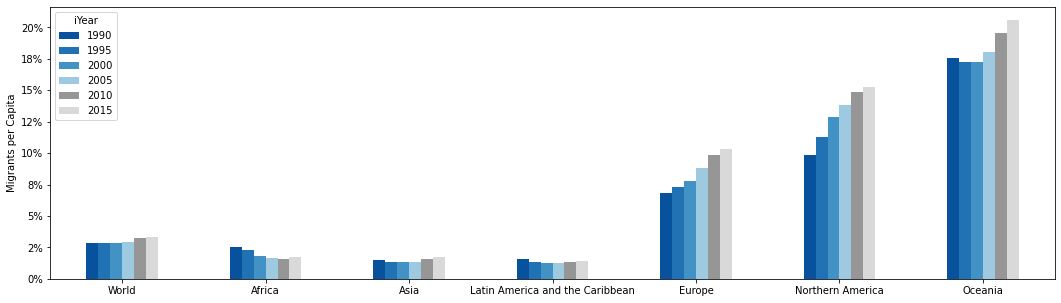

In [17]:
## Generate figure 2 - compare M/P by year by continent

Tf2a = TAFGH.groupby(["iContinentID","iYear"]).agg({"iMigrants":"sum","fPopulation":"sum","iRefugee":"sum"})

Tf2a = Tf2a.reset_index()

# tDimContinent TB
## >>> int - iContinentID - T7.5
## >>> string - sContinentName t7.4

Tf2b = pd.merge(Tf2a,TB,how='inner',on=["iContinentID"]).drop(["iContinentID"],axis=1)

Tf2b["MoP"] = Tf2b["iMigrants"] / (Tf2b["fPopulation"] * 1000)
Tf2b["RoP"] = Tf2b["iRefugee"] / (Tf2b["fPopulation"] * 1000)

## get world avg

Tf2c = Tf2b.groupby("iYear").agg({"iMigrants":"sum","fPopulation":"sum","iRefugee":"sum"})

Tf2c["sContinentName"] = "World"

Tf2c["MoP"] = Tf2c["iMigrants"] / (Tf2c["fPopulation"] * 1000)
Tf2c["RoP"] = Tf2c["iRefugee"] / (Tf2c["fPopulation"] * 1000)

Tf2c = Tf2c.reset_index()

#print(Tf2b)
#print(Tf2c)

Tf2 = pd.concat([Tf2c,Tf2b]).pivot_table(index=['sContinentName'], columns=['iYear'], values='MoP')

Tf2["sortOrder"] = [2,3,5,4,6,7,1]

Tf2.sort_values(by = ['sortOrder'],inplace=True)
Tf2 = Tf2.drop("sortOrder",axis=1)

print(Tf2)

plt.rcParams["figure.figsize"] = (18, 5)

bx = Tf2.plot.bar(rot=0, colormap=clr.ListedColormap(custom_palette))
bx.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.xlabel('')
plt.ylabel('Migrants per Capita')

/tmp/ipykernel_44/2685600759.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Tf3a["Class"] = ""
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


                                       iCountryID                             
Class                           1 Least Developed 2 Less Developed 3 Developed
sContinentName                                                                
World                                    0.206897         0.551724    0.241379
Africa                                   0.586207         0.413793         NaN
Asia                                     0.180000         0.800000    0.020000
Latin America and the Caribbean          0.020833         0.979167         NaN
Europe                                        NaN              NaN    1.000000
Northern America                              NaN              NaN    1.000000
Oceania                                  0.173913         0.739130    0.086957


Text(0, 0.5, '% split developmental status')

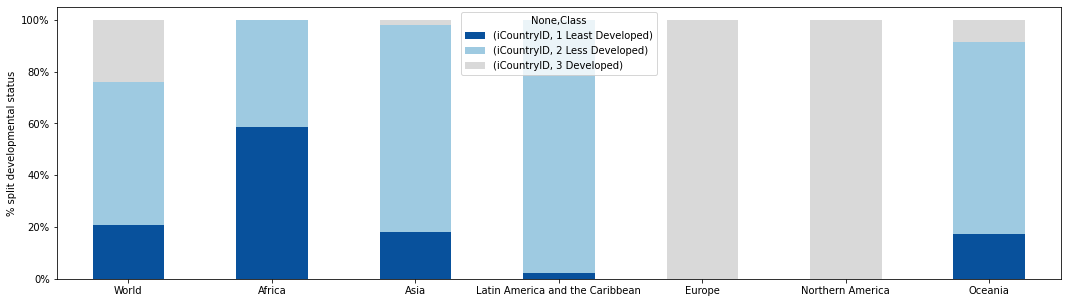

In [18]:
## Generate Figure 3 - developmental status breakdown by continent

Tf3a = TA[["iCountryID","iContinentID","bLessDeveloped","bLeastDeveloped","bDeveloped"]]

Tf3a["Class"] = ""

for i in range(len(TA1)):
    if Tf3a.iloc[i].loc["bDeveloped"] == 1:
        Tf3a.iloc[i, 5] = "3 Developed"
    elif Tf3a.iloc[i].loc["bLeastDeveloped"] == 1:
        Tf3a.iloc[i, 5] = "1 Least Developed"
    else: 
        Tf3a.iloc[i, 5] = "2 Less Developed"
        
# tDimContinent TB
## >>> int - iContinentID - T7.5
## >>> string - sContinentName t7.4

Tf3b = pd.merge(Tf3a,TB,how='inner',on=["iContinentID"]).drop(["iContinentID"],axis=1)

Tf3b["value"] = 0

Tf3c = (Tf3b.groupby(["sContinentName","Class"])["iCountryID"].count()/Tf3b.groupby(["sContinentName"])['iCountryID'].count())
Tf3d = (Tf3b.groupby(["Class"])["iCountryID"].count()/Tf3b['iCountryID'].count())

Tf3c = Tf3c.reset_index()
Tf3d = Tf3d.reset_index()

Tf3d["sContinentName"] = "World"

Tf3 = pd.concat([Tf3c,Tf3d])

Tf3 = Tf3.set_index(['sContinentName','Class']).unstack()

Tf3["sortOrder"] = [2,3,5,4,6,7,1]

Tf3.sort_values(by = ['sortOrder'],inplace=True)
Tf3 = Tf3.drop("sortOrder",axis=1)

print(Tf3)

cx = Tf3.plot.bar(stacked=True, rot=0, colormap=clr.ListedColormap(custom_palette))

cx.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.xlabel('')
plt.ylabel('% split developmental status')

  iContinentID                   sContinentName
0          903                           Africa
1          904  Latin America and the Caribbean
2          905                 Northern America
3          908                           Europe
4          909                          Oceania
5          935                             Asia
     iCountryID iYear  iMigrants  fPopulation iRefugee  iContinentID  \
0             4  1990      57686    12067.570       25           935   
12           12  1990     273954    25912.364   169107           903   
18           16  1990      21283       47.044        0           909   
30           24  1990      33517    11127.870    12000           903   
36           28  1990      12029       61.906        0           904   
...         ...   ...        ...          ...      ...           ...   
1347        862  1990    1025009    19861.959     1750           904   
1353        876  1990       1402       13.880        0           909   
1359        882 

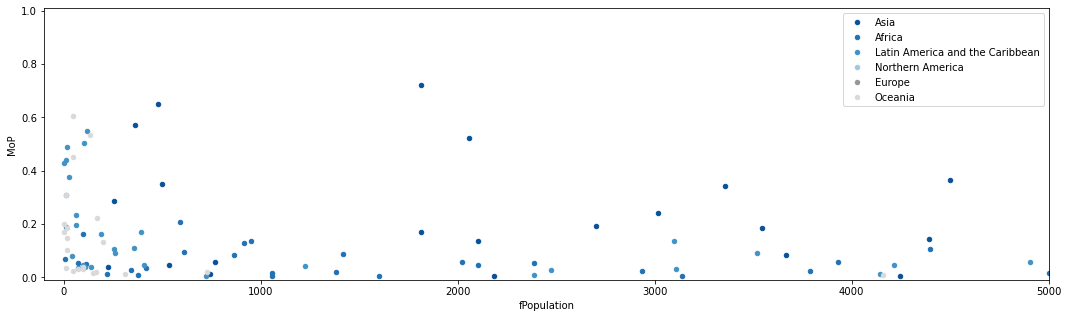

In [19]:
## generate figure 4 - scatter plot comparing m/p with total population - looking for outliers

#   iContinentID                   sContinentName
# 0          903                           Africa
# 1          904  Latin America and the Caribbean
# 2          905                 Northern America
# 3          908                           Europe
# 4          909                          Oceania
# 5          935                             Asia

colors = ['#08519c','#2171b5','#4292c6','#9ecae1','#969696','#d9d9d9']

custom_palette = sns.color_palette(colors)

Tf4a = TAFGH[TAFGH["iYear"] == 1990]
Tf4 = Tf4a[Tf4a["bDeveloped"] == 0]

print(TB)
## plot by continents

dx = Tf4[Tf4["iContinentID"] == 935].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Asia', 
                                                  
            color=colors[0])
dx1 = Tf4[Tf4["iContinentID"] == 903].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Africa',              
            color=colors[1]
            , ax=dx)
dx2 = Tf4[Tf4["iContinentID"] == 904].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Latin America and the Caribbean',              
            color=colors[2]
            , ax=dx)
dx3 = Tf4[Tf4["iContinentID"] == 905].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Northern America',              
            color=colors[3]
            , ax=dx)
dx4 = Tf4[Tf4["iContinentID"] == 908].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Europe',              
            color=colors[4]
            , ax=dx)
dx5 = Tf4[Tf4["iContinentID"] == 909].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Oceania',              
            color=colors[5]
            , ax=dx)

plt.xlim(-100, 5000)
plt.ylim(-.01,1.01)
    
## plot by class

#ax1 = df.plot(kind='scatter', x='a', y='b', color='r')    
#ax2 = df.plot(kind='scatter', x='c', y='d', color='g', ax=ax1)    
#ax3 = df.plot(kind='scatter', x='e', y='f', color='b', ax=ax1)

print(Tf4)

  iContinentID                   sContinentName
0          903                           Africa
1          904  Latin America and the Caribbean
2          905                 Northern America
3          908                           Europe
4          909                          Oceania
5          935                             Asia
     iCountryID iYear  iMigrants  fPopulation iRefugee  iContinentID  \
0             4  1990      57686    12067.570       25           935   
12           12  1990     273954    25912.364   169107           903   
18           16  1990      21283       47.044        0           909   
30           24  1990      33517    11127.870    12000           903   
36           28  1990      12029       61.906        0           904   
...         ...   ...        ...          ...      ...           ...   
1347        862  1990    1025009    19861.959     1750           904   
1353        876  1990       1402       13.880        0           909   
1359        882 

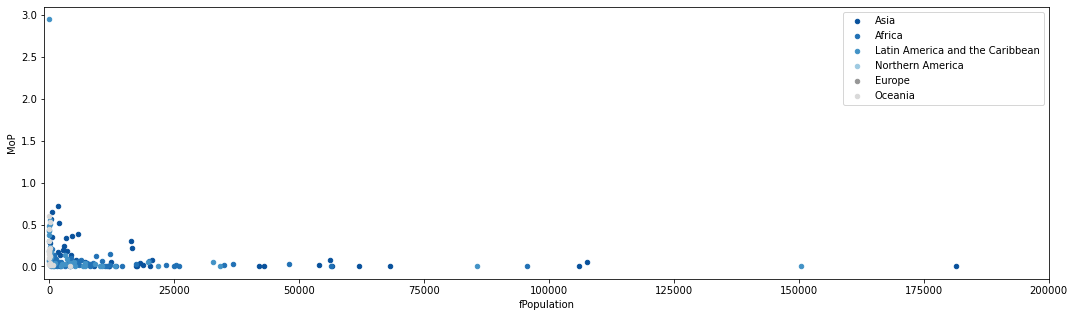

In [20]:
## generate figure 4 - scatter plot comparing m/p with total population - looking for outliers

#   iContinentID                   sContinentName
# 0          903                           Africa
# 1          904  Latin America and the Caribbean
# 2          905                 Northern America
# 3          908                           Europe
# 4          909                          Oceania
# 5          935                             Asia

colors = ['#08519c','#2171b5','#4292c6','#9ecae1','#969696','#d9d9d9']

custom_palette = sns.color_palette(colors)

Tf4a = TAFGH[TAFGH["iYear"] == 1990]
Tf4 = Tf4a[Tf4a["bDeveloped"] == 0]

print(TB)
## plot by continents

dx = Tf4[Tf4["iContinentID"] == 935].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Asia', 
                                                  
            color=colors[0])
dx1 = Tf4[Tf4["iContinentID"] == 903].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Africa',              
            color=colors[1]
            , ax=dx)
dx2 = Tf4[Tf4["iContinentID"] == 904].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Latin America and the Caribbean',              
            color=colors[2]
            , ax=dx)
dx3 = Tf4[Tf4["iContinentID"] == 905].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Northern America',              
            color=colors[3]
            , ax=dx)
dx4 = Tf4[Tf4["iContinentID"] == 908].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Europe',              
            color=colors[4]
            , ax=dx)
dx5 = Tf4[Tf4["iContinentID"] == 909].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Oceania',              
            color=colors[5]
            , ax=dx)

plt.xlim(-1000, 200000)
#plt.ylim(-.01,1.01)
    
## plot by class

#ax1 = df.plot(kind='scatter', x='a', y='b', color='r')    
#ax2 = df.plot(kind='scatter', x='c', y='d', color='g', ax=ax1)    
#ax3 = df.plot(kind='scatter', x='e', y='f', color='b', ax=ax1)

print(Tf4)

  iContinentID                   sContinentName
0          903                           Africa
1          904  Latin America and the Caribbean
2          905                 Northern America
3          908                           Europe
4          909                          Oceania
5          935                             Asia
     iCountryID iYear  iMigrants  fPopulation iRefugee  iContinentID  \
0             4  1990      57686    12067.570       25           935   
6             8  1990      66013     3281.453     3000           908   
12           12  1990     273954    25912.364   169107           903   
18           16  1990      21283       47.044        0           909   
24           20  1990      38904       54.511        0           908   
...         ...   ...        ...          ...      ...           ...   
1347        862  1990    1025009    19861.959     1750           904   
1353        876  1990       1402       13.880        0           909   
1359        882 

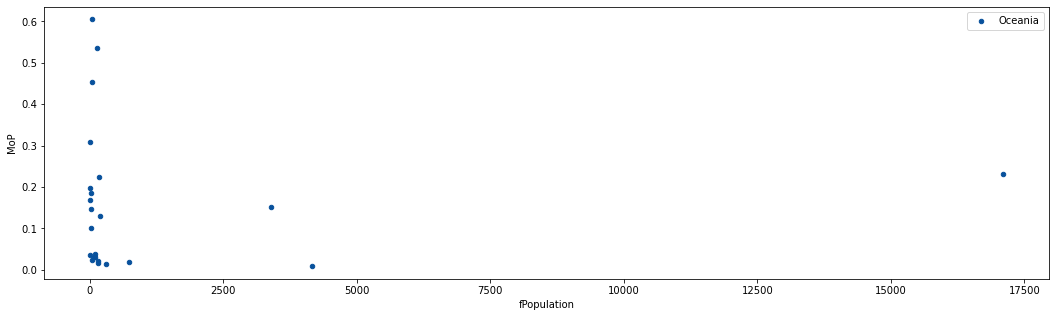

In [21]:
## generate figure 4 - scatter plot comparing m/p with total population - looking for outliers

#   iContinentID                   sContinentName
# 0          903                           Africa
# 1          904  Latin America and the Caribbean
# 2          905                 Northern America
# 3          908                           Europe
# 4          909                          Oceania
# 5          935                             Asia

colors = ['#08519c','#2171b5','#4292c6','#9ecae1','#969696','#d9d9d9']

custom_palette = sns.color_palette(colors)

Tf4 = TAFGH[TAFGH["iYear"] == 1990]
#Tf4 = Tf4a[Tf4a["bDeveloped"] == 0]

print(TB)
## plot by continents

dx = Tf4[Tf4["iContinentID"] == 909].plot.scatter(x='fPopulation',
            y='MoP',
            label = 'Oceania',              
            color=colors[0])

#plt.xlim(-1000, 200000)
#plt.ylim(-.01,1.01)
    
## plot by class

#ax1 = df.plot(kind='scatter', x='a', y='b', color='r')    
#ax2 = df.plot(kind='scatter', x='c', y='d', color='g', ax=ax1)    
#ax3 = df.plot(kind='scatter', x='e', y='f', color='b', ax=ax1)

print(Tf4)